## Model Training

In [1]:
import math
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, plot_tree 
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
import optuna
from eclyon.transforms import process_df

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('cleaned_restaurant_inspection_data_3.csv')
df.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,ACTION,VIOLATION CODE,...,Census Tract,BIN,BBL,NTA,Location,days_since_last,avg_last_3_scores,inspection_year,inspection_month,inspection_weekday
0,30075445,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVENUE,10462.0,7188924968,Bakery Products/Desserts,Establishment Closed by DOHMH. Violations were...,06D,...,25200.0,2045445.0,2.041270e+09,BX37,POINT (-73.855971889932 40.848231224526),730.0,25.02185,2023,1,1
1,30075445,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVENUE,10462.0,7188924968,Bakery Products/Desserts,Establishment Closed by DOHMH. Violations were...,08C,...,25200.0,2045445.0,2.041270e+09,BX37,POINT (-73.855971889932 40.848231224526),0.0,21.00000,2023,1,1
2,30075445,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVENUE,10462.0,7188924968,Bakery Products/Desserts,Establishment Closed by DOHMH. Violations were...,04L,...,25200.0,2045445.0,2.041270e+09,BX37,POINT (-73.855971889932 40.848231224526),0.0,21.00000,2023,1,1
3,30075445,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVENUE,10462.0,7188924968,Bakery Products/Desserts,Establishment Closed by DOHMH. Violations were...,06C,...,25200.0,2045445.0,2.041270e+09,BX37,POINT (-73.855971889932 40.848231224526),0.0,21.00000,2023,1,1
4,30075445,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVENUE,10462.0,7188924968,Bakery Products/Desserts,Establishment Closed by DOHMH. Violations were...,10F,...,25200.0,2045445.0,2.041270e+09,BX37,POINT (-73.855971889932 40.848231224526),0.0,21.00000,2023,1,1


In [3]:
X, y, nas = process_df(df, y_field = 'SCORE')

In [4]:
pd.concat([X.head(), X.tail()])

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,ACTION,VIOLATION CODE,...,inspection_month,inspection_weekday,ZIPCODE_na,Latitude_na,Longitude_na,Community Board_na,Council District_na,Census Tract_na,BIN_na,BBL_na
0,30075445,12616,1,37,1539,10462.0,2680,8,1,43,...,1,1,False,False,False,False,False,False,False,False
1,30075445,12616,1,37,1539,10462.0,2680,8,1,52,...,1,1,False,False,False,False,False,False,False,False
2,30075445,12616,1,37,1539,10462.0,2680,8,1,27,...,1,1,False,False,False,False,False,False,False,False
3,30075445,12616,1,37,1539,10462.0,2680,8,1,42,...,1,1,False,False,False,False,False,False,False,False
4,30075445,12616,1,37,1539,10462.0,2680,8,1,63,...,1,1,False,False,False,False,False,False,False,False
275284,50178121,5420,3,2065,839,10013.0,22895,8,5,63,...,10,2,False,False,False,False,False,False,False,False
275285,50178178,8261,2,5403,220,11220.0,24256,64,5,63,...,10,0,False,False,False,False,False,False,False,False
275286,50178178,8261,2,5403,220,11220.0,24256,64,5,64,...,10,0,False,False,False,False,False,False,False,False
275287,50178190,1678,2,4657,1627,11216.0,10685,23,5,42,...,11,0,False,False,False,False,False,False,False,False
275288,50178194,1407,2,6682,164,11209.0,22697,7,5,63,...,10,0,False,False,False,False,False,False,False,False


### Divide the training set and the test set

In [5]:
n_total = len(df)
print('full number of data points : {}'.format(n_total))

full number of data points : 275289


In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set size:", X_train.shape)
print("validation set size:", X_valid.shape)

Training set size: (220231, 35)
validation set size: (55058, 35)


### 1. The random forest model

In [7]:
def rmse(y_gold, y_pred): 
    return math.sqrt(((y_gold - y_pred)**2).mean())

In [8]:
def print_score(m, X_train, y_train, X_valid, y_valid):
    print('RMSE on train set: {:.4f}'.format(rmse(m.predict(X_train), y_train)))
    print('RMSE on valid set: {:.4f}'.format(rmse(m.predict(X_valid), y_valid)))
    print('R^2 on train set: {:.4f}'.format(m.score(X_train, y_train)))
    print('R^2 on valid set: {:.4f}'.format(m.score(X_valid, y_valid)))
    if hasattr(m, 'oob_score_'): print('R^2 on oob set: {:.4f}'.format(m.oob_score_))
    return

In [9]:
model_1 = RandomForestRegressor(
    n_estimators = 800, 
    criterion = 'squared_error', 
    
    max_depth = 15,
    min_samples_split = 2, 
    min_samples_leaf = 1,
    min_weight_fraction_leaf = 0.0, 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0, 
    ccp_alpha = 0.0, 
 
    max_features = 0.5, 
    bootstrap = True,
    oob_score = True, 
    max_samples = None,
    
    warm_start = False, 
    n_jobs = -1,
    random_state = 42,
    verbose = 0, 
)

model_1.fit(X_train, y_train)
print_score(model_1, X_train, y_train, X_valid, y_valid)

RMSE on train set: 6.8830
RMSE on valid set: 8.3262
R^2 on train set: 0.8651
R^2 on valid set: 0.8057
R^2 on oob set: 0.8073


In [10]:
model_2 = RandomForestRegressor(
    n_estimators = 500, 
    criterion = 'squared_error', 
    
    max_depth = 12,
    min_samples_split = 20, 
    min_samples_leaf = 10,
    min_weight_fraction_leaf = 0.0, 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0, 
    ccp_alpha = 0.0, 
 
    max_features = 0.5, 
    bootstrap = True,
    oob_score = True, 
    max_samples = None,
    
    warm_start = False, 
    n_jobs = -1,
    random_state = 42,
    verbose = 0, 
)

model_2.fit(X_train, y_train)
print_score(model_2, X_train, y_train, X_valid, y_valid)

RMSE on train set: 7.9641
RMSE on valid set: 8.4430
R^2 on train set: 0.8194
R^2 on valid set: 0.8002
R^2 on oob set: 0.8025


Use Optuna

In [11]:
def objective_rf(trial, X_train, y_train, X_val, y_val):
   
    params = {
        'n_estimators': 500,  
        'criterion': 'squared_error',

        'max_depth': trial.suggest_int('max_depth', 10, 30),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 100),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        'max_samples': trial.suggest_float('max_samples', 0.5, 1.0),
        
        'n_jobs': -1,
        'random_state': 42
    }
    
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    
    preds = model.predict(X_val)
    r2 = metrics.r2_score(y_val, preds)
    return r2

In [12]:
study = optuna.create_study(study_name="random_forest",
                            direction="maximize")

study.optimize(lambda trial: objective_rf(trial, X_train, y_train, X_valid, y_valid), n_trials=30)

[I 2025-12-06 22:03:21,863] A new study created in memory with name: random_forest
[I 2025-12-06 22:04:39,819] Trial 0 finished with value: 0.7935154576892011 and parameters: {'max_depth': 23, 'min_samples_leaf': 56, 'max_features': 0.650184668478714, 'max_samples': 0.5604522246016734}. Best is trial 0 with value: 0.7935154576892011.
[I 2025-12-06 22:06:24,223] Trial 1 finished with value: 0.7925717808698071 and parameters: {'max_depth': 22, 'min_samples_leaf': 77, 'max_features': 0.549680444740196, 'max_samples': 0.8599706215174876}. Best is trial 0 with value: 0.7935154576892011.
[I 2025-12-06 22:08:20,989] Trial 2 finished with value: 0.7970899797646167 and parameters: {'max_depth': 13, 'min_samples_leaf': 42, 'max_features': 0.6021315799400744, 'max_samples': 0.9858611175322466}. Best is trial 2 with value: 0.7970899797646167.
[I 2025-12-06 22:10:16,905] Trial 3 finished with value: 0.790694438531607 and parameters: {'max_depth': 17, 'min_samples_leaf': 80, 'max_features': 0.550218

In [13]:
print("optimal parameter:", study.best_params)
print("optimal score", study.best_value)

optimal parameter: {'max_depth': 17, 'min_samples_leaf': 4, 'max_features': 0.8644813807403116, 'max_samples': 0.6174399174374072}
optimal score 0.8032601874378635


Using the parameters I find above.

In [14]:
model_3 = RandomForestRegressor(
    n_estimators = 500, 
    criterion = 'squared_error', 
    
    max_depth = 25,
    min_samples_leaf = 1,
 
    max_features = 0.35, 
    max_samples = 0.87,
    
    n_jobs = -1,
    random_state = 42,
)

model_3.fit(X_train, y_train)
print_score(model_3, X_train, y_train, X_valid, y_valid)

RMSE on train set: 4.0789
RMSE on valid set: 8.2944
R^2 on train set: 0.9526
R^2 on valid set: 0.8072


### We find in **random forest model**, `model_2` has best **$R^2$**: 0.800 in validation set and **$R^2$**: 0.819 in training set.

### 2. XG boost model

In [8]:
def reg_perf(regressor, X_training, X_validation, y_true_training, y_true_validation):
   
    y_pred_training = regressor.predict(X_training)
    y_pred_validation = regressor.predict(X_validation)
    rmse_training = metrics.root_mean_squared_error(y_true_training, y_pred_training)
    rmse_validation = metrics.root_mean_squared_error(y_true_validation, y_pred_validation)
    r2_training = metrics.r2_score(y_true_training, y_pred_training)
    r2_validation = metrics.r2_score(y_true_validation, y_pred_validation)
    print("RMSE on training set : {:.3f}".format(rmse_training))
    print("RMSE on validation set : {:.3f}".format(rmse_validation))
    print("R^2 on training set : {:.3f}".format(r2_training))
    print("R^2 on validation set : {:.3f}".format(r2_validation))

In [16]:
model_xg_1 = XGBRegressor(
    n_estimators = 800,  
    objective = 'reg:squarederror',
    n_jobs = -1,
    random_state = 42,
    tree_method = 'hist',            
    learning_rate = 0.1, 
    max_depth = 10, 
    min_child_weight = 47, 
    subsample = 0.5, 
    colsample_bytree = 0.5, 
    reg_lambda = 5,
    reg_alpha = 3,
)

model_xg_1.fit(X_train, y_train)
reg_perf(model_xg_1, X_train, X_valid, y_train, y_valid)

RMSE on training set : 5.564
RMSE on validation set : 8.107
R^2 on training set : 0.912
R^2 on validation set : 0.816


Use Optuna

In [17]:
def objective_xgb(trial, X_train, y_train, X_val, y_val):

    params = {
        'n_estimators': 3000,  
        'objective': 'reg:squarederror',
        'n_jobs': -1,
        'random_state': 42,
        'tree_method': 'hist',
        
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        
        'min_child_weight': trial.suggest_int('min_child_weight', 30, 150),
        'subsample': trial.suggest_float('subsample', 0.5, 0.8),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.8),
        
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 20.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 20.0),
    }
    
    model = XGBRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False 
    )
    
    preds = model.predict(X_val)
    r2 = metrics.r2_score(y_val, preds)
    
    return r2

In [18]:
study_xgb = optuna.create_study(study_name="xg_boost", 
                                direction="maximize")
study_xgb.optimize(lambda trial: objective_xgb(trial, X_train, y_train, X_valid, y_valid), n_trials=50)

[I 2025-12-06 23:45:45,942] A new study created in memory with name: xg_boost
[I 2025-12-06 23:46:02,960] Trial 0 finished with value: 0.800446223009879 and parameters: {'learning_rate': 0.03907373302000189, 'max_depth': 3, 'min_child_weight': 144, 'subsample': 0.771009115964664, 'colsample_bytree': 0.6912456246259044, 'reg_lambda': 10.095522006508475, 'reg_alpha': 19.97741620144481}. Best is trial 0 with value: 0.800446223009879.
[I 2025-12-06 23:46:24,470] Trial 1 finished with value: 0.8052224678768725 and parameters: {'learning_rate': 0.021064772199002737, 'max_depth': 5, 'min_child_weight': 141, 'subsample': 0.685500513560471, 'colsample_bytree': 0.6180211436723041, 'reg_lambda': 18.767651387939384, 'reg_alpha': 11.449907505223157}. Best is trial 1 with value: 0.8052224678768725.
[I 2025-12-06 23:46:52,362] Trial 2 finished with value: 0.8081400877177594 and parameters: {'learning_rate': 0.011842372920745279, 'max_depth': 7, 'min_child_weight': 118, 'subsample': 0.6451344285226862

In [19]:
print("optimal parameter:", study_xgb.best_params)
print("optional score:", study_xgb.best_value)

optimal parameter: {'learning_rate': 0.04948700770572531, 'max_depth': 7, 'min_child_weight': 31, 'subsample': 0.7928737359443427, 'colsample_bytree': 0.5068744058805716, 'reg_lambda': 12.95489185075752, 'reg_alpha': 9.354138862531528}
optional score: 0.8198264691354934


In [20]:
model_xg_2 = XGBRegressor(
    n_estimators = 800,  
    objective = 'reg:squarederror',
    n_jobs = -1,
    random_state = 42,
    tree_method = 'hist',            
    learning_rate = 0.04587946938575663, 
    max_depth = 7, 
    min_child_weight = 30, 
    subsample = 0.7983339264706694, 
    colsample_bytree = 0.5591344538757566, 
    reg_lambda = 7.999603129722958,
    reg_alpha = 0.5786659140538726,
)

model_xg_2.fit(X_train, y_train)
reg_perf(model_xg_2, X_train, X_valid, y_train, y_valid)

RMSE on training set : 7.430
RMSE on validation set : 8.202
R^2 on training set : 0.843
R^2 on validation set : 0.811


In [21]:
model_xg_3 = XGBRegressor(
    n_estimators = 3000,  
    objective = 'reg:squarederror',
    n_jobs = -1,
    random_state = 42,
    tree_method = 'hist',            
    learning_rate = 0.04587946938575663, 
    max_depth = 7, 
    min_child_weight = 30, 
    subsample = 0.7983339264706694, 
    colsample_bytree = 0.5591344538757566, 
    reg_lambda = 7.999603129722958,
    reg_alpha = 0.5786659140538726,
)

model_xg_3.fit(X_train, y_train)
reg_perf(model_xg_3, X_train, X_valid, y_train, y_valid)

RMSE on training set : 6.055
RMSE on validation set : 8.022
R^2 on training set : 0.896
R^2 on validation set : 0.820


Use Optuna with early stopping

In [22]:
def objective_xgb(trial, X_train, y_train, X_val, y_val):

    params = {
        'n_estimators': 3000,  
        'objective': 'reg:squarederror',
        'n_jobs': -1,
        'random_state': 42,
        'tree_method': 'hist',
        
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        
        'min_child_weight': trial.suggest_int('min_child_weight', 30, 150),
        'subsample': trial.suggest_float('subsample', 0.5, 0.8),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.8),
        
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 20.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 20.0),
    }
    
    model = XGBRegressor(early_stopping_rounds=50,
                         **params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False 
    )
    
    preds = model.predict(X_val)
    r2 = metrics.r2_score(y_val, preds)
    
    return r2

In [23]:
study_xgb = optuna.create_study(study_name="xg_boost", 
                                direction="maximize")
study_xgb.optimize(lambda trial: objective_xgb(trial, X_train, y_train, X_valid, y_valid), n_trials=50)

[I 2025-12-07 00:05:36,261] A new study created in memory with name: xg_boost
[I 2025-12-07 00:05:47,376] Trial 0 finished with value: 0.7979530080548721 and parameters: {'learning_rate': 0.020442754887455686, 'max_depth': 3, 'min_child_weight': 53, 'subsample': 0.7130326350317873, 'colsample_bytree': 0.792991558980814, 'reg_lambda': 17.695231003970775, 'reg_alpha': 9.927420857568993}. Best is trial 0 with value: 0.7979530080548721.
[I 2025-12-07 00:06:05,744] Trial 1 finished with value: 0.8157320636861901 and parameters: {'learning_rate': 0.0353186502357707, 'max_depth': 7, 'min_child_weight': 62, 'subsample': 0.7263721685515262, 'colsample_bytree': 0.5964444988694794, 'reg_lambda': 8.238766592889643, 'reg_alpha': 11.621362070761164}. Best is trial 1 with value: 0.8157320636861901.
[I 2025-12-07 00:06:19,727] Trial 2 finished with value: 0.8092207408638818 and parameters: {'learning_rate': 0.04457616208075153, 'max_depth': 5, 'min_child_weight': 139, 'subsample': 0.7966672338152744, 

In [24]:
print("optimal parameter:", study_xgb.best_params)
print("optional score:", study_xgb.best_value)

optimal parameter: {'learning_rate': 0.043755084950132944, 'max_depth': 7, 'min_child_weight': 66, 'subsample': 0.7842945681101852, 'colsample_bytree': 0.7316001722352349, 'reg_lambda': 12.455827927171978, 'reg_alpha': 16.27992416679777}
optional score: 0.8170694391833662


In [25]:
model_xg_4 = XGBRegressor(
    n_estimators = 3000,  
    objective = 'reg:squarederror',
    n_jobs = -1,
    random_state = 42,
    tree_method = 'hist',            
    learning_rate = 0.04770195370119892, 
    max_depth = 7, 
    min_child_weight = 30, 
    subsample = 0.7329253597402302, 
    colsample_bytree = 0.7858080821898186, 
    reg_lambda = 10.270115350619623,
    reg_alpha = 18.489147444182933,
)

model_xg_4.fit(X_train, y_train)
reg_perf(model_xg_4, X_train, X_valid, y_train, y_valid)

RMSE on training set : 5.826
RMSE on validation set : 8.052
R^2 on training set : 0.903
R^2 on validation set : 0.818


### We find in **XG boost model**, `model_xg_2` has best **$R^2$**: 0.811 in validation set and **$R^2$**: 0.843 in training set.

### 3. Cat boost model

In [9]:
model_cat_1 = CatBoostRegressor(
    iterations=2000,          
    learning_rate=0.02,       
    depth=6,                  
    loss_function='RMSE',
    eval_metric='R2',         
    l2_leaf_reg=5,           
    rsm=0.7,                 
    subsample=0.7,           
    random_seed=42,
)

model_cat_1.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid),
    early_stopping_rounds=50, 
    use_best_model=True
)

reg_perf(model_cat_1, X_train, X_valid, y_train, y_valid)

0:	learn: 0.0267534	test: 0.0264438	best: 0.0264438 (0)	total: 9.28ms	remaining: 18.5s
1:	learn: 0.0527902	test: 0.0521452	best: 0.0521452 (1)	total: 18ms	remaining: 18s
2:	learn: 0.0779078	test: 0.0769412	best: 0.0769412 (2)	total: 29.4ms	remaining: 19.6s
3:	learn: 0.1013981	test: 0.1000767	best: 0.1000767 (3)	total: 37.5ms	remaining: 18.7s
4:	learn: 0.1249662	test: 0.1234421	best: 0.1234421 (4)	total: 47.2ms	remaining: 18.8s
5:	learn: 0.1477943	test: 0.1460882	best: 0.1460882 (5)	total: 54.9ms	remaining: 18.2s
6:	learn: 0.1675769	test: 0.1655996	best: 0.1655996 (6)	total: 63.3ms	remaining: 18s
7:	learn: 0.1862292	test: 0.1839814	best: 0.1839814 (7)	total: 71.2ms	remaining: 17.7s
8:	learn: 0.2060514	test: 0.2035281	best: 0.2035281 (8)	total: 80.7ms	remaining: 17.9s
9:	learn: 0.2250662	test: 0.2223222	best: 0.2223222 (9)	total: 92ms	remaining: 18.3s
10:	learn: 0.2437600	test: 0.2408482	best: 0.2408482 (10)	total: 101ms	remaining: 18.2s
11:	learn: 0.2617257	test: 0.2586977	best: 0.25869

Use Optuna

In [27]:
def objective_catb(trial, X_tr, y_tr, X_val, y_val):
    
    params = {
        'iterations': 2000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 4, 8), 
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 20),
        'rsm': trial.suggest_float('rsm', 0.5, 0.9),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9),
        'bootstrap_type': 'Bernoulli', 
        'random_strength': trial.suggest_float('random_strength', 1, 10),
        'loss_function': 'RMSE',
        'eval_metric': 'R2',
        'random_seed': 42,
        'verbose': False
    }

    model = CatBoostRegressor(**params)
    
    model.fit(
        X_tr, y_tr,
        eval_set=(X_val, y_val),
        early_stopping_rounds=50,
        use_best_model=True
    )
    
    return model.get_best_score()['validation']['R2']

In [28]:
study_cb = optuna.create_study(direction="maximize", study_name="catboost_opt")
study_cb.optimize(lambda trial: objective_catb(trial, X_train, y_train, X_valid, y_valid), n_trials=20 )

[I 2025-12-07 01:04:52,574] A new study created in memory with name: catboost_opt
[I 2025-12-07 01:05:06,205] Trial 0 finished with value: 0.8056773327982223 and parameters: {'learning_rate': 0.05433485371198816, 'depth': 5, 'l2_leaf_reg': 6, 'rsm': 0.791134755528836, 'subsample': 0.8206999546569523, 'random_strength': 7.456712401945325}. Best is trial 0 with value: 0.8056773327982223.
[I 2025-12-07 01:05:27,073] Trial 1 finished with value: 0.8103133529276763 and parameters: {'learning_rate': 0.06880151459995576, 'depth': 8, 'l2_leaf_reg': 14, 'rsm': 0.6634426365296523, 'subsample': 0.6708591201224161, 'random_strength': 2.9438508413324915}. Best is trial 1 with value: 0.8103133529276763.
[I 2025-12-07 01:21:04,430] Trial 2 finished with value: 0.799343674643999 and parameters: {'learning_rate': 0.021618905794120673, 'depth': 4, 'l2_leaf_reg': 14, 'rsm': 0.8155266806439899, 'subsample': 0.7152616919382537, 'random_strength': 7.430277009122041}. Best is trial 1 with value: 0.8103133529

In [29]:
print("optimal parameter:", study_cb.best_params)
print("optional score:", study_cb.best_value)

optimal parameter: {'learning_rate': 0.09054266289607386, 'depth': 8, 'l2_leaf_reg': 9, 'rsm': 0.6213062866891068, 'subsample': 0.8852763687667153, 'random_strength': 4.473555037253962}
optional score: 0.813696388257013


In [30]:
model_cat_2 = CatBoostRegressor(
    iterations=2000,          
    learning_rate=0.09219668945916258,       
    depth=8,                  
    loss_function='RMSE',
    eval_metric='R2',         
    l2_leaf_reg=20,           
    rsm=0.7533896450500435,                 
    subsample=0.8846691007243696,           
    random_seed=42,
    random_strength = 1.9319463735380067
)

model_cat_2.fit(X_train, y_train,eval_set=(X_valid, y_valid),early_stopping_rounds=50, use_best_model=True)
reg_perf(model_cat_2, X_train, X_valid, y_train, y_valid)

0:	learn: 0.1213595	test: 0.1199341	best: 0.1199341 (0)	total: 12.1ms	remaining: 24.2s
1:	learn: 0.2271432	test: 0.2246807	best: 0.2246807 (1)	total: 22.6ms	remaining: 22.6s
2:	learn: 0.3118427	test: 0.3084223	best: 0.3084223 (2)	total: 33.8ms	remaining: 22.5s
3:	learn: 0.3844345	test: 0.3806230	best: 0.3806230 (3)	total: 45.8ms	remaining: 22.8s
4:	learn: 0.4461445	test: 0.4419439	best: 0.4419439 (4)	total: 56.5ms	remaining: 22.5s
5:	learn: 0.4949107	test: 0.4901902	best: 0.4901902 (5)	total: 69.7ms	remaining: 23.2s
6:	learn: 0.5382245	test: 0.5335623	best: 0.5335623 (6)	total: 80.5ms	remaining: 22.9s
7:	learn: 0.5752638	test: 0.5704011	best: 0.5704011 (7)	total: 91.4ms	remaining: 22.8s
8:	learn: 0.6053452	test: 0.6003329	best: 0.6003329 (8)	total: 102ms	remaining: 22.5s
9:	learn: 0.6313928	test: 0.6260647	best: 0.6260647 (9)	total: 114ms	remaining: 22.7s
10:	learn: 0.6535781	test: 0.6481710	best: 0.6481710 (10)	total: 125ms	remaining: 22.6s
11:	learn: 0.6718801	test: 0.6666189	best: 0

### We find in **Cat boost model**, `model_cat_1` has best **$R^2$**: 0.805 in validation set and **$R^2$**: 0.813 in training set.

### 4. Gradient Boosting

In [31]:
model_gb_1 = GradientBoostingRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,              
    min_samples_leaf=50,     
    subsample=0.7,           
    max_features='sqrt',     
    loss='squared_error',
    n_iter_no_change=20,     
    validation_fraction=0.1, 
    random_state=42,
    verbose=0
)

model_gb_1 .fit(X_train, y_train)
reg_perf(model_gb_1, X_train, X_valid, y_train, y_valid)

RMSE on training set : 8.118
RMSE on validation set : 8.456
R^2 on training set : 0.812
R^2 on validation set : 0.800


In [32]:
model_gb_2 = GradientBoostingRegressor(
    n_estimators=3000,         
    learning_rate=0.02,        
  
    max_depth=7,               
    min_samples_leaf=30,       
    max_features=0.5,           
    
    subsample=0.7,
    loss='squared_error',
    
    n_iter_no_change=20,
    validation_fraction=0.1,
    random_state=42,
    verbose=0
)

model_gb_2.fit(X_train, y_train)
reg_perf(model_gb_2, X_train, X_valid, y_train, y_valid)

RMSE on training set : 7.274
RMSE on validation set : 8.204
R^2 on training set : 0.849
R^2 on validation set : 0.811


### We find in **Gradient boost model**, `model_gb_2` has best **$R^2$**: 0.811 in validation set and **$R^2$**: 0.849 in training set.

### Overall, the best model I find is **Cat boost model**, `model_cat_1` has best **$R^2$**: 0.805 in validation set and **$R^2$**: 0.813 in training set.

### Feature important

The importance of built-in features

0:	learn: 0.0267534	total: 14ms	remaining: 28.1s
1:	learn: 0.0527902	total: 22.4ms	remaining: 22.4s
2:	learn: 0.0779078	total: 32.2ms	remaining: 21.4s
3:	learn: 0.1013981	total: 41.4ms	remaining: 20.7s
4:	learn: 0.1249662	total: 49ms	remaining: 19.6s
5:	learn: 0.1477943	total: 56.3ms	remaining: 18.7s
6:	learn: 0.1675769	total: 63.7ms	remaining: 18.1s
7:	learn: 0.1862292	total: 71.5ms	remaining: 17.8s
8:	learn: 0.2060514	total: 79.3ms	remaining: 17.5s
9:	learn: 0.2250662	total: 87.6ms	remaining: 17.4s
10:	learn: 0.2437600	total: 95.8ms	remaining: 17.3s
11:	learn: 0.2617257	total: 104ms	remaining: 17.2s
12:	learn: 0.2789097	total: 113ms	remaining: 17.2s
13:	learn: 0.2960990	total: 121ms	remaining: 17.2s
14:	learn: 0.3126896	total: 128ms	remaining: 17s
15:	learn: 0.3281284	total: 136ms	remaining: 16.9s
16:	learn: 0.3428717	total: 144ms	remaining: 16.8s
17:	learn: 0.3572664	total: 151ms	remaining: 16.6s
18:	learn: 0.3716576	total: 159ms	remaining: 16.5s
19:	learn: 0.3851851	total: 166ms	re

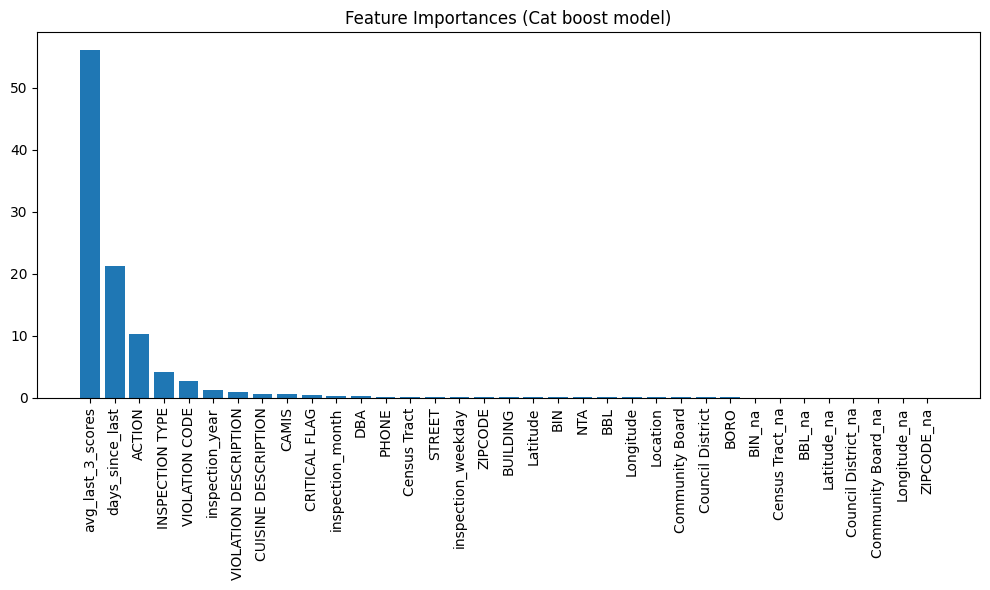

In [12]:
model_cat_1.fit(X_train, y_train)

importances = model_cat_1.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print(f"{X_train.columns[indices[f]]}: {importances[indices[f]]:.4f}")

plt.figure(figsize=(10,6))
plt.title("Feature Importances (Cat boost model)")
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

Permutation Importance

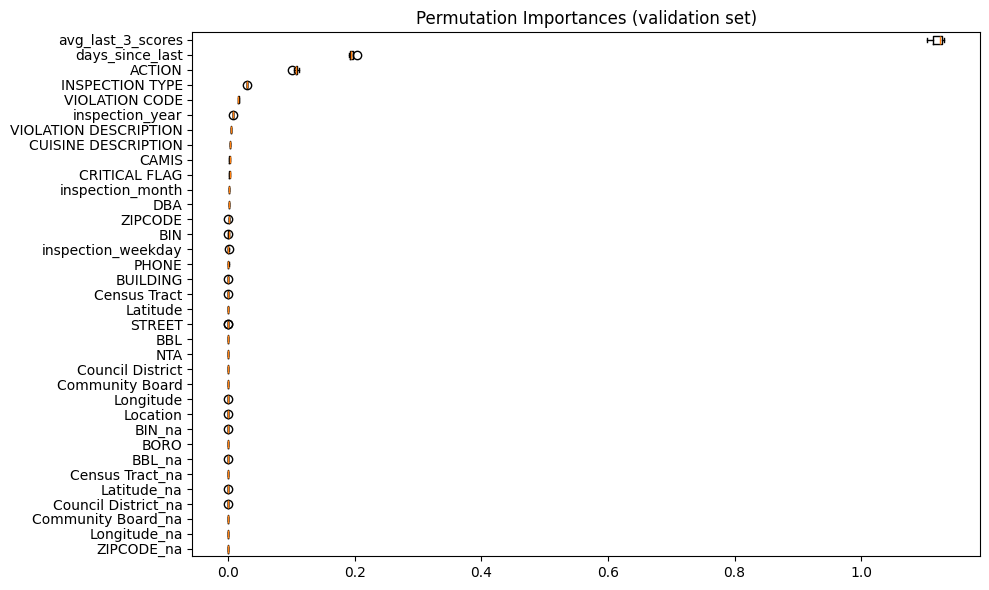

In [13]:
r = permutation_importance(model_cat_1, X_valid, y_valid, n_repeats=10, random_state=42)

sorted_idx = r.importances_mean.argsort()

plt.figure(figsize=(10,6))
plt.boxplot(r.importances[sorted_idx].T, vert=False, labels=X_valid.columns[sorted_idx])
plt.title("Permutation Importances (validation set)")
plt.tight_layout()
plt.show()

In [14]:
bool_filter = r.importances_mean > 0.005
bool_filter

array([False, False, False, False, False, False, False, False,  True,
        True, False, False,  True, False, False, False, False, False,
       False, False, False, False,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False])

In [15]:
X.columns

Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE DESCRIPTION', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'INSPECTION TYPE', 'Latitude',
       'Longitude', 'Community Board', 'Council District', 'Census Tract',
       'BIN', 'BBL', 'NTA', 'Location', 'days_since_last', 'avg_last_3_scores',
       'inspection_year', 'inspection_month', 'inspection_weekday',
       'ZIPCODE_na', 'Latitude_na', 'Longitude_na', 'Community Board_na',
       'Council District_na', 'Census Tract_na', 'BIN_na', 'BBL_na'],
      dtype='object')